In [ ]:
!pip install pydicom
!pip install opencv-python
!pip install pillow # optional
!pip install pandas
!pip install tensorflow==2.15.0
!pip install tensorflow-gan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
# Check that imports for the rest of the file work.
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from glob import glob
import os
import time
from datetime import date, datetime
import cv2
import string
import random
from IPython import display
import tensorflow_gan as tfgan

# Allow matplotlib images to render immediately.
%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Disable noisy outputs.

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dissertation/ProstrateX/Additional Data/ProstateX-Findings-Test.csv')
df.head()

,Unnamed: 0,ProxID,fid,pos,zone,ClinSig
0,4,ProstateX-0222,1,-15.3211048332002 21.0878985229492 -11.5281921...,PZ,False
1,5,ProstateX-0280,1,-32.5957 24.2277 20.6089,TZ,False
2,6,ProstateX-0291,2,-71.5076 44.5422646972656 -52.0640193603516,PZ,False
3,7,ProstateX-0291,1,-54.5944 44.4664 -54.0555,PZ,False
4,8,ProstateX-0302,1,-40.9102 20.4419 -4.15981,TZ,False


In [ ]:
findings_dataset = pd.read_csv('/content/drive/MyDrive/Dissertation/ProstrateX/Additional Data/ProstateX-Findings-Test.csv')
clinsig_findings_dataset = findings_dataset.loc[findings_dataset['ClinSig'] == True]
clinsig_findings_dataset
clinsig_findings_dataset.loc[findings_dataset['zone'] == 'AS'].count()
# print(clinsig_findings_dataset)
# for index, row in clinsig_findings_dataset.iterrows():
#   print(row['ProxID'])

Unnamed: 0    20
ProxID        20
fid           20
pos           20
zone          20
ClinSig       20
dtype: int64

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dissertation/ProstrateX/images/manifest-A3Y4AE4o5818678569166032044/metadata.csv')
clinsig_file_locations = []
for index, row in clinsig_findings_dataset.iterrows():
  df_row = df.loc[(df['Subject ID'] == row['ProxID']) & (df['Series Description'].str.contains("ADC"))]

# df.loc[(df['Subject ID'] == 'ProstateX-0002') & (df['Series Description'] == 'ep2ddifftraDYNDISTADC')]

In [ ]:
BASE_PATH = '/content/drive/MyDrive/Dissertation/ProstrateX/images/manifest-A3Y4AE4o5818678569166032044/PROSTATEx'

In [ ]:
image_paths = glob(os.path.join(BASE_PATH,'**/**/*ADC*'))
print(len(image_paths))

0


In [ ]:
def combineSlices(directory):
  files = []
  for file in glob(directory):
    if(').dcm' in file):
      continue
    files.append(pydicom.dcmread(file))

  # print("file count: {}".format(len(files)))

  # skip files with no SliceLocation (eg scout views)
  slices = []
  for f in files:
      if hasattr(f, 'SliceLocation'):
          slices.append(f)

  # ensure they are in the correct order
  slices = sorted(slices, key=lambda s: s.SliceLocation)
  # print("Slices in combination {} out of {}".format(len(slices), len(files)))
  return slices

In [ ]:
# Save findings in a dataframe
findings_df = pd.read_csv('/content/drive/MyDrive/Dissertation/ProstrateX/Additional Data/ProstateX-Findings-Test.csv')

# Array consisting of the clinical significance of each patient
clin_sig = []

# Array consisting of Patient IDs
patient_identifiers = [image_paths[i][101:115] for i in range(len(image_paths))]

# Array to save images
resized_images = []
batches = []
for i, id in enumerate(patient_identifiers):
  sig = findings_df['ClinSig'].loc[findings_dataset['ProxID'] == id]
  slices = combineSlices('{}/*.dcm'.format(image_paths[i]))
  temp = []
  if not sig.empty and bool(sig.iloc[0]):
    clin_sig.append(1)
  else:
    clin_sig.append(0)

  for j in range(len(slices)):
    if not sig.empty:
      r_image = cv2.resize(np.array(slices[j].pixel_array),(128,128))
      resized_images.append(r_image)
      if len(temp) < 8:
        temp.append(r_image)
      if bool(sig.iloc[0]):
        clin_sig.append(1)
        continue
      clin_sig.append(0)

In [ ]:
from numpy import expand_dims

def normalize3DArray(array3d):
  X = array3d.astype('float32')
  return (X - 127.5)/127.5

In [ ]:
training_dataset = resized_images_np
training_dataset = normalize3DArray(resized_images_np)
print(training_dataset[0,:,:])
td_shape = list(training_dataset.shape)
td_shape.append(1)
training_dataset = np.reshape(training_dataset, td_shape)


[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


In [ ]:
today = date.today().strftime("%d-%m-%Y")
np.save('/content/drive/MyDrive/Dissertation/ProstrateX/ADC_images_resized_{}.npy'.format(today), resized_images_np)
np.save('/content/drive/MyDrive/Dissertation/ProstrateX/ADC_training.npy_{}'.format(today), training_dataset)

In [ ]:
def getImageAttributes(slices):
  # pixel aspects, assuming all slices are the same
  ps = slices[0].PixelSpacing
  ss = slices[0].SliceThickness
  return [ps, ss]

def get3DArrayFromSlices(slices):
  # create 3D array
  img_shape = list(slices[0].pixel_array.shape)
  img_shape.append(len(slices))
  img3d = np.zeros(img_shape)

  # fill 3D array with the images from the files
  for i, s in enumerate(slices):
      img2d = s.pixel_array
      img3d[:, :, i] = img2d
  return img3d

In [ ]:
def generate3DImage(array3d, ps, ss):
  print(array3d.shape)
  img_shape = list(array3d.shape)
  ax_aspect = (ps[1]/ps[0])
  sag_aspect = ps[1]/ss
  cor_aspect = ss/ps[0]
  # plot 3 orthogonal slices
  a1 = plt.subplot(2, 2, 1)
  plt.imshow(array3d[:, :, img_shape[2]//2])
  a1.set_aspect(ax_aspect)

  a2 = plt.subplot(2, 2, 2)
  plt.imshow(array3d[:, img_shape[1]//2, :])
  a2.set_aspect(sag_aspect)

  a3 = plt.subplot(2, 2, 3)
  plt.imshow(array3d[img_shape[0]//2, :, :].T)
  a3.set_aspect(cor_aspect)

  plt.show()

In [ ]:
def generate3DImageFromSlices(directory):
  slices = combineSlices(directory)
  img3d = get3DArrayFromSlices(slices)
  # normalizedImg3d = normalize3DArray(img3d)
  [pixel_spacing, slice_thickness] = getImageAttributes(slices)
  generate3DImage(img3d, pixel_spacing, slice_thickness)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 256)))
    assert model.output_shape == (None, 32, 32, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

generator = make_generator_model()

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# print(generated_image.shape)
# generate3DImage(np.array(generated_image), [1,1], 0.5)

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    print(model.output_shape)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Flatten(input_shape=(64, 64)))
    print(model.output_shape)
    model.add(layers.Dense(1))  # Output layer
    # print(model.output_shape)
    # model.add(layers.Dense(1, activation='sigmoid'))
    return model
discriminator = make_discriminator_model()
print(generated_image.shape)
decision = discriminator(generated_image)
print (decision)

(None, 64, 64, 128)
(None, 16, 16, 128)
(None, 32768)
(1, 128, 128, 1)
tf.Tensor([[-0.0003917]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Nadam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Nadam(1e-6)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Dissertation/ProstrateX/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed = tf.clip_by_value(seed,clip_value_min=-2.0, clip_value_max=2.0)

In [ ]:
print(len(resized_images))
resized_images_np = np.asarray(resized_images)
clin_sig_np = np.asarray(clin_sig)

print(resized_images_np.shape)
print(clin_sig_np.shape)
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(resized_images_np[0,:,:], cmap='gray')

NameError: name 'resized_images' is not defined

In [ ]:
training_dataset = np.load('/content/drive/MyDrive/Dissertation/ProstrateX/ADC_training.npy_02-03-2024.npy')

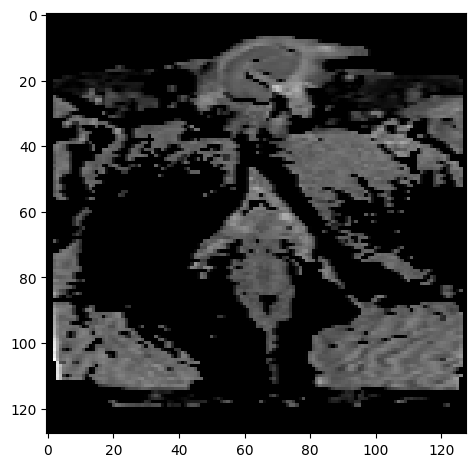

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(training_dataset[0,:,:], cmap='gray')

In [ ]:
BUFFER_SIZE = len(training_dataset)
BATCH_SIZE = 16
print(BUFFER_SIZE)

2833


In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
@tf.function
def get_fid_score(real_image, gen_image, num_inception_images = 1):
  resized_real_images = tf.image.resize(real_image, [128, 128], method=tf.image.ResizeMethod.BILINEAR)
  resized_generated_images = tf.image.resize(gen_image, [128, 128], method=tf.image.ResizeMethod.BILINEAR)
  num_batches = BATCH_SIZE // num_inception_images
  fid = tfgan.eval.frechet_inception_distance(resized_real_images, resized_generated_images, num_batches=num_batches)
  return fid

In [ ]:
@tf.function
def get_inception_score(images, num_inception_images = 1):
  resized_images = tf.image.resize(images, [128, 128], method=tf.image.ResizeMethod.BILINEAR)

  num_batches = BATCH_SIZE // num_inception_images
  inc_score = tfgan.eval.inception_score(resized_images, num_batches=num_batches)

  return inc_score

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    noise = tf.clip_by_value(noise,clip_value_min=-2.0, clip_value_max=2.0)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)

      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [ ]:
def generate_and_save_images(model, epoch, test_input, run_id, date, timestamp):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  dir = '/content/drive/MyDrive/Dissertation/ProstrateX/AugmentedImages/{}-{}-gan_images-{}/'.format(date, run_id, timestamp)
  file_name = '{}/image_at_epoch_{:04d}.png'.format(dir, epoch)
  os.makedirs(dir, exist_ok=True)
  plt.savefig(file_name)
  plt.show()
  return predictions

In [ ]:
fid_scores = []
incept_scores = []
steps = []
timestamp = int(datetime.now().timestamp())

In [ ]:
def train(dataset, epochs):
  id = id_generator()
  today = date.today()
  today = today.strftime("%d-%m-%Y")
  for epoch in range(epochs):
    print("Epoch {}".format(epoch))
    start = time.time()

    for image_batch in dataset:
      image_batch = np.expand_dims(image_batch, axis=0)
      train_step(image_batch)

    img_start = time.time()
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    gen_images = generate_and_save_images(generator,
                             epoch + 1,
                             seed, id, today, timestamp)
    fid_score = get_fid_score(dataset[0], gen_images, 8)
    incept_score = get_inception_score(gen_images, 8)
    fid_scores.append(fid_score)
    incept_scores.append(incept_score)
    steps.append(epoch)
    print ('Time for image is {} sec'.format(time.time()-img_start))

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print("saving checkpint")
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed, id, today)

In [ ]:
image_batch = np.expand_dims(training_dataset[0], axis=0)
real_image = discriminator(image_batch)
print(real_image)

gen_loss = generator_loss(generated_image)
disc_loss = discriminator_loss(real_image, decision)
print(gen_loss, disc_loss)

tf.Tensor([[-0.44104335]], shape=(1, 1), dtype=float32)
tf.Tensor(0.69345427, shape=(), dtype=float32) tf.Tensor(1.6312158, shape=(), dtype=float32)


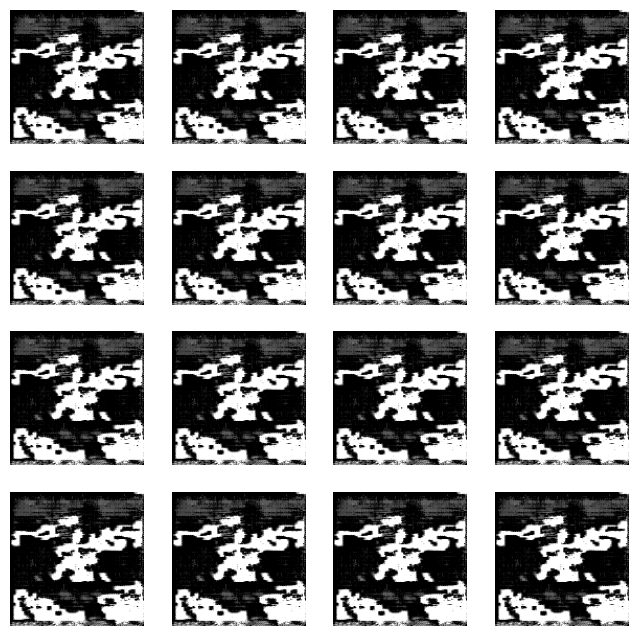

In [ ]:
train(training_dataset, EPOCHS)
np.save('/content/drive/MyDrive/Dissertation/ProstrateX/fid_scores_{}_{}'.format(today, timestamp), fid_scores)
np.save('/content/drive/MyDrive/Dissertation/ProstrateX/incept_scores_{}_{}'.format(today, timestamp), incept_scores)

In [ ]:
plt.title('MNIST Frechet distance per step')
plt.plot(steps, frechet_distances)
plt.figure()

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))